In [ ]:
import pandas as pd
import warnings
import requests, zipfile, io, os, re
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [ ]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [ ]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [ ]:
download_and_extract(healthy_url, healthy_path)

In [ ]:
download_and_extract(parkinson_url, parkinson_path)

In [ ]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'
healthy = []
parkinson = []

In [ ]:
for filename in os.listdir(healthy_signals):
  if re.search('sigSp', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    healthy.append(df)

for filename in os.listdir(parkinson_signals):
 if re.search('sigSp', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    parkinson.append(df)


In [ ]:
def preprocess(X, y):
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
  return X_train, X_valid, y_train, y_valid

In [ ]:
def create_dataset(healthy, parkinson, seq):
  X = []
  y = []

  # healthy signals
  for df in healthy:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(0)

  # parkinson signals
  for df in parkinson:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(1)

  return np.array(X), np.array(y)


In [ ]:
def train_model(X_train, X_valid, y_train, y_valid):
  model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 6)),
  keras.layers.GRU(128),
  keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X_train, y_train, epochs = 15, batch_size = 64)
  return model.evaluate(X_valid, y_valid)



In [ ]:
sequence_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
loss = []
accuracy = []


for sequence in sequence_list:
  X, y = create_dataset(healthy, parkinson, sequence)
  X_train, X_valid, y_train, y_valid = preprocess(X, y)
  curr_loss, curr_accuracy = train_model(X_train, X_valid, y_train, y_valid)
  
  loss.append(curr_loss)
  accuracy.append(curr_accuracy)
  print(curr_loss, curr_accuracy)



Epoch 1/15
587/587 [==============================] - 28s 47ms/step - loss: 0.4773 - accuracy: 0.7810
Epoch 2/15
587/587 [==============================] - 25s 43ms/step - loss: 0.3819 - accuracy: 0.8285
Epoch 3/15
587/587 [==============================] - 24s 41ms/step - loss: 0.3253 - accuracy: 0.8561
Epoch 4/15
587/587 [==============================] - 24s 41ms/step - loss: 0.2914 - accuracy: 0.8749
Epoch 5/15
587/587 [==============================] - 24s 41ms/step - loss: 0.2583 - accuracy: 0.8903
Epoch 6/15
587/587 [==============================] - 24s 41ms/step - loss: 0.2404 - accuracy: 0.9010
Epoch 7/15
587/587 [==============================] - 24s 41ms/step - loss: 0.2067 - accuracy: 0.9155
Epoch 8/15
587/587 [==============================] - 23s 40ms/step - loss: 0.1815 - accuracy: 0.9270
Epoch 9/15
587/587 [==============================] - 23s 39ms/step - loss: 0.1598 - accuracy: 0.9358
Epoch 10/15
587/587 [==============================] - 23s 39ms/step - loss: 0.143

In [ ]:
loss

[0.17033903300762177,
 0.2425549179315567,
 0.22459883987903595,
 0.23740552365779877,
 0.2939128577709198,
 0.2831626534461975,
 0.332041472196579,
 0.3024689257144928,
 0.32843583822250366,
 0.37449318170547485]

In [ ]:
accuracy

[0.9351881742477417,
 0.9050876498222351,
 0.9105821847915649,
 0.8972485065460205,
 0.8809267282485962,
 0.8864373564720154,
 0.8640850186347961,
 0.8654513955116272,
 0.8627451062202454,
 0.8490152955055237]

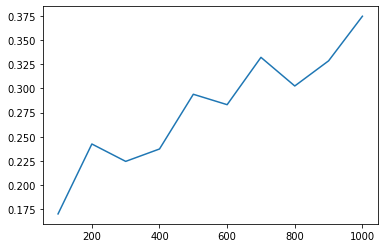

In [ ]:
plt.plot(sequence_list, loss)

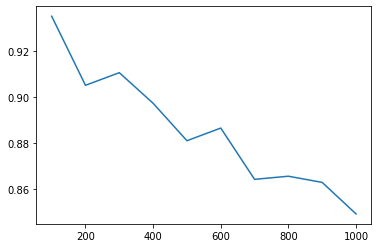

In [ ]:
plt.plot(sequence_list, accuracy)